# Biblioteki

In [248]:
import numpy as np
import pandas as pd
import json
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['figure.figsize'] = [15, 10]
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, Lasso
import statsmodels.api as sm

import itertools

# Deklaracje

In [249]:
def plot_ts(ts):
    fig, ax = plt.subplots()
    ts_roll_mean = ts.rolling(window=12).mean()
    ts_roll_std = ts.rolling(window=12).std()
    
    ts.plot(color='blue', label='Original', use_index=False)
    ts_roll_mean.plot(color='red', label="Rolling mean", use_index=False)
    ts_roll_std.plot(color='black', label="Rolling std", use_index=False)
    
    ax.set_xticklabels(ts.index)
    fig.autofmt_xdate()
    
    
    plt.xlabel('Date')
    plt.ylabel('Return ratio')
    plt.show()
    
def perform_dft(ts):
    #Perform Augmented Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(y_train, autolag='AIC')
    add_col = []
    values = list(dftest[0:4])
    for key,value in dftest[4].items():
        add_col.append('Critical Value (%s)'%key)
        values.append(value)

    dfoutput = pd.DataFrame(data = [values], index=['Wartość'], columns=['Test Statistic','p-value','#Lags Used','Number of Observations Used']+add_col)
    display(dfoutput)

def decompose(ts):
    decomposition = seasonal_decompose(ts, freq=10) 
    decomposition.plot()
    plt.show()
    
def find_best_hparameters(ts, x, pmax, d, qmax):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for p in range(pmax+1):
        for q in range(qmax+1):
            order = (p,d,q)
            try:
                model = SARIMAX(ts, x, order=order, freq='B', trend='c')
                results = model.fit(disp=False)
                rmse_value = rmse(results.fittedvalues, ts)
                rmse_value_list.append(rmse_value)
                order_list.append(order)
            except Exception as e:
                errors_dict[str(order)] = {'error_str': str(e)}
    
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best10 = tuple(order for order, rmse_value in results[:10])
    return best10, results

# def find_best_extra_vars(ts, x_array, order, n_max=4):
#     errors_dict = {}
#     rmse_value_list = []
#     order_list = []
#     for i in range(2, n_max+1):
#         print(i)
#         try:
#             model = SARIMAX(ts, order=order, freq='B')
#             results = model.fit()
#             rmse_value = rmse(results.fittedvalues, ts)
#             rmse_value_list.append(rmse_value)
#             order_list.append(order)
#         except Exception as e:
#             errors_dict[str(order)] = {'error_str': str(e)}
    
#     errors = pd.DataFrame.from_dict(errors_dict, orient='index')
#     display(errors)
    
#     results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
#     best10 = tuple(order for order, rmse_value in results[:10])
#     return best10, results

def select_best_orders_from_best10(ts, x, best10):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for order in best10:
        try:
            model = SARIMAX(ts, x, order=order, freq='B', trend='c')
            results = model.fit(disp=False)
            rmse_value = rmse(results.fittedvalues, ts)
            rmse_value_list.append(rmse_value)
            order_list.append(order)
        except Exception as e:
            errors_dict[str(order)] = {'error_str': str(e)}
            
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best = results[0][0]
    return best, results

def test_orders(ts, orders):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for order in orders:
        try:
            model = ARIMA(ts, order=order, freq='B')
            results = model.fit(disp=False)
            rmse_value = rmse(results.fittedvalues, ts)
            rmse_value_list.append(rmse_value)
            order_list.append(order)
        except Exception as e:
            errors_dict[str(order)] = {'error_str': str(e)}
            
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best = results[0][0]
    return best, results

def show_est_plot(ts, x_array=None, order=None, zero=False, naiwny=False, label="Wykres"):
    if zero == True:
        z = [0]*len(ts)
        rmse_value = rmse(ts, z)
        plt.plot(ts.index, z, label="Zero", color='red')
        plt.plot(ts.index, ts, label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
    elif naiwny == True:
        rmse_value = rmse(ts[1:], ts.shift()[1:])
        plt.plot(ts[1:].index, ts.shift()[1:], label="Naiwny", color='red')
        plt.plot(ts[1:].index, ts[1:], label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
    else:
        model = SARIMAX(ts, x_array, order=order, freq='B', trend='c')
        results = model.fit(disp=False)
        rmse_value = rmse(results.fittedvalues, ts)
        plt.plot(ts.index, results.fittedvalues, label=label, color='red')
        plt.plot(ts.index, ts, label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
        

In [250]:
best_results = {}

# Wczytanie zbiorów

In [251]:
train = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/train_ekon.csv', index_col=0)
val1 = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/valid1_ekon.csv', index_col=0)
val2 = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/valid2_ekon.csv', index_col=0)
val3 = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/valid3_ekon.csv', index_col=0)
test = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/test_ekon.csv', index_col=0)

train.index = pd.to_datetime(train.index)
val1.index = pd.to_datetime(val1.index)
val2.index = pd.to_datetime(val2.index)
val3.index = pd.to_datetime(val3.index)
test.index = pd.to_datetime(test.index)

whole = pd.concat([train, val1, val2, val3, test])

train1 = train.asfreq('B', method='bfill')
train2 = pd.concat([train, val1]).asfreq('B', method='bfill')
train3 = pd.concat([train, val1, val2]).asfreq('B', method='bfill')

val1 = val1.asfreq('B', method='bfill')
val2 = val2.asfreq('B', method='bfill')
val3 = val3.asfreq('B', method='bfill')
test = test.asfreq('B', method='bfill')

display(train.head(3))
display(val1.head(3))
display(val2.head(3))
display(val3.head(3))
display(test.head(3))
display(whole.head(3))

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

# Wybór X

In [252]:
first_iter_columns = [
    'gross_margin',
    'operating_margin',
    'ebig margin',
    'pre-tax profit margin',
    'receiveable_turnover',
    'days_sales_in_receivables',
    'roe',
    'return on tangible equity',
    'roi',
    'book value per share',
    'EMA',
    'Will_R',
    'DEMA',
    'HT_TRENDLINE',
    'KAMA',
    'MIDPOINT',
    'MIDPRICE',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
    'PLUS_DI',
    'NATR',
    'AVGPRICE',
    'MEDPRICE',
    'TYPPRICE',
    'WCLPRICE',
    'LINEARREG',
    'LINEARREG_INTERCEPT',
    'TSF',
    'ADD',
    'MAX',
    'MIN',
    'MININDEX',
    'MULT',
    'SUM',
    'ATAN',
    'CEIL',
    'FLOOR',
    'TAN',
    'AMD_',
    'Intel_',
    'Data Science_',
    'fintech_',
    'cryptocurrency_',
    'bitcoin_',
    'cryptocurrency miner_',
    'Battlefield_',
    'Just Cause_',
    "Assassin's Creed_",
    'gaming PC_',
    'blockchain_news',
    'gaming_news',
    'Battlefield_news',
    "Assassin's Creed_news",
    'AMD__scaled',
    'Intel__scaled',
    'Data Science__scaled',
    'fintech__scaled',
    'Azure__scaled',
    'e-sport__scaled',
    'Battlefield__scaled',
    'Just Cause__scaled',
    "Assassin's Creed__scaled",
    'Forza Motorsport__scaled',
    'gaming PC__scaled',
    'gaming_news_scaled',
    'Battlefield_news_scaled',
    'Just Cause_news_scaled',
    "Assassin's Creed_news_scaled",
    'NasdaqTech',
    'TTWO_gaming',
    'UBSFY_gaming',
    'fps',
    'NVIDIA_news_publikacja_(3, 6]',
    'UBSFY_gaming_rr',
    'AMD_rr',
    'BTC_rolling_variance',
    'ATVI_gaming_rolling_variance',
    'UBSFY_gaming_rolling_variance',
    'ATVI_gaming_diff_1',
    'TTWO_gaming_diff_1',
    'UBSFY_gaming_diff_1',
    'fps_transformed_interpolated_diff_1_shift_2',
    'fps_interpolated_transformed_diff_1_shift_2',
    'rolling variance',
    'close',
    'day_of_week',
    'day_of_year',
    'week'
]

## Trening 1

In [253]:
train1["day_of_week"] = train1.index.dayofweek
train1["day_of_year"] = train1.index.dayofweek
train1["week"] = train1.index.week
train1["quarter"] = train1.index.quarter

val1["day_of_week"] = val1.index.dayofweek
val1["day_of_year"] = val1.index.dayofweek
val1["week"] = val1.index.week
val1["quarter"] = val1.index.quarter



y_train = train1['return ratio']
x_train = train1[first_iter_columns]

y_test = val1['return ratio']
x_test = val1[x_train.columns]

In [254]:
clf = Lasso(alpha=0.01)
featureSelection = SelectFromModel(clf)
featureSelection.fit(x_train, y_train)
train1_variables = x_train.columns[featureSelection.get_support()].tolist()
print(train1_variables)

x_train = train1[train1_variables]
x_test = val1[train1_variables]

['Will_R', 'TSF']


In [255]:
pmax = 3
qmax = 3
d = 0

best10, results = find_best_hparameters(y_train, x_train, pmax=pmax, qmax=qmax, d=d)
print(best10)
print(results)
print('###############################################')
best, results = select_best_orders_from_best10(y_test, x_test, best10)
best_results['train1'] = results
print(best)
print(results)

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to 

,error_str
"(1, 0, 1)",Non-stationary starting autoregressive paramet...
"(2, 0, 1)",Non-stationary starting autoregressive paramet...


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


((3, 0, 3), (3, 0, 2), (1, 0, 3), (0, 0, 3), (2, 0, 3), (3, 0, 0), (3, 0, 1), (2, 0, 2), (1, 0, 2), (0, 0, 2))
[((3, 0, 3), 0.019832601180753955), ((3, 0, 2), 0.019836877219418497), ((1, 0, 3), 0.019838387125746756), ((0, 0, 3), 0.019838397403759655), ((2, 0, 3), 0.019838774337508955), ((3, 0, 0), 0.019840049330980197), ((3, 0, 1), 0.019840059109164403), ((2, 0, 2), 0.019860336920414168), ((1, 0, 2), 0.019866721099215976), ((0, 0, 2), 0.01987367756074646), ((2, 0, 0), 0.019873758450640083), ((0, 0, 0), 0.01987882928250371), ((1, 0, 0), 0.01988183161031353), ((0, 0, 1), 0.01988220797614412)]
###############################################


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

""


(2, 0, 3)
[((2, 0, 3), 0.022834804286413973), ((1, 0, 3), 0.022898050495036088), ((3, 0, 2), 0.022936622354577815), ((0, 0, 3), 0.022968609115734073), ((3, 0, 3), 0.023435326428110716), ((3, 0, 0), 0.023447814744293218), ((3, 0, 1), 0.023481299462332243), ((2, 0, 2), 0.024183318914961564), ((1, 0, 2), 0.024547306373653814), ((0, 0, 2), 0.02457934079131771)]


## Trening 2

In [256]:
train2["day_of_week"] = train2.index.dayofweek
train2["day_of_year"] = train2.index.dayofweek
train2["week"] = train2.index.week
train2["quarter"] = train2.index.quarter

val2["day_of_week"] = val2.index.dayofweek
val2["day_of_year"] = val2.index.dayofweek
val2["week"] = val2.index.week
val2["quarter"] = val2.index.quarter



y_train = train2['return ratio']
x_train = train2[first_iter_columns]

y_test = val2['return ratio']
x_test = val2[x_train.columns]

In [257]:
clf = Lasso(alpha=0.01)
featureSelection = SelectFromModel(clf)
featureSelection.fit(x_train, y_train)
train2_variables = x_train.columns[featureSelection.get_support()].tolist()
print(train2_variables)

x_train = train2[train2_variables]
x_test = val2[train2_variables]

['Will_R', 'T3', 'TSF', 'CEIL', 'FLOOR', 'close']


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [258]:
pmax = 3
qmax = 3
d = 0

best10, results = find_best_hparameters(y_train, x_train, pmax=pmax, qmax=qmax, d=d)
print(best10)
print(results)
print('###############################################')
best, results = select_best_orders_from_best10(y_test, x_test, best10)
best_results['train2'] = results
print(best)
print(results)

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to 

,error_str
"(2, 0, 1)",Non-stationary starting autoregressive paramet...
"(2, 0, 2)",Non-stationary starting autoregressive paramet...
"(2, 0, 3)",Non-stationary starting autoregressive paramet...
"(3, 0, 2)",Non-stationary starting autoregressive paramet...
"(3, 0, 3)",Non-stationary starting autoregressive paramet...


((3, 0, 0), (3, 0, 1), (1, 0, 2), (0, 0, 3), (2, 0, 0), (0, 0, 2), (1, 0, 1), (0, 0, 1), (1, 0, 0), (0, 0, 0))
[((3, 0, 0), 0.017898363401995437), ((3, 0, 1), 0.01789849902022775), ((1, 0, 2), 0.017899054291513134), ((0, 0, 3), 0.01790125363800584), ((2, 0, 0), 0.01790186954819468), ((0, 0, 2), 0.017901879153763213), ((1, 0, 1), 0.017902800438195754), ((0, 0, 1), 0.017903134456753702), ((1, 0, 0), 0.017903233716607285), ((0, 0, 0), 0.017909129762290327), ((1, 0, 3), 0.017911364465549626)]
###############################################


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,error_str
"(1, 0, 2)",Non-stationary starting autoregressive paramet...


(2, 0, 0)
[((2, 0, 0), 0.020465224571511648), ((1, 0, 0), 0.020473582524287704), ((3, 0, 1), 0.020482398687413677), ((3, 0, 0), 0.020483974815141998), ((1, 0, 1), 0.020493161629777948), ((0, 0, 1), 0.020497982940743092), ((0, 0, 0), 0.020513228245557995), ((0, 0, 2), 0.02060505086801916), ((0, 0, 3), 0.0206171515618396)]


## Trening 3

In [259]:
train3["day_of_week"] = train3.index.dayofweek
train3["day_of_year"] = train3.index.dayofweek
train3["week"] = train3.index.week
train3["quarter"] = train3.index.quarter

val3["day_of_week"] = val3.index.dayofweek
val3["day_of_year"] = val3.index.dayofweek
val3["week"] = val3.index.week
val3["quarter"] = val3.index.quarter



y_train = train3['return ratio']
x_train = train3[first_iter_columns]

y_test = val3['return ratio']
x_test = val3[x_train.columns]

In [260]:
clf = Lasso(alpha=0.01)
featureSelection = SelectFromModel(clf)
featureSelection.fit(x_train, y_train)
train3_variables = x_train.columns[featureSelection.get_support()].tolist()
print(train3_variables)

x_train = train3[train3_variables]
x_test = val3[train3_variables]

['Will_R', 'T3', 'TSF', 'CEIL', 'close']


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [261]:
pmax = 3
qmax = 3
d = 0

best10, results = find_best_hparameters(y_train, x_train, pmax=pmax, qmax=qmax, d=d)
print(best10)
print(results)
print('###############################################')
best, results = select_best_orders_from_best10(y_test, x_test, best10)
best_results['train3'] = results
print(best)
print(results)

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to 

,error_str
"(2, 0, 1)",Non-stationary starting autoregressive paramet...
"(3, 0, 3)",Non-stationary starting autoregressive paramet...


((0, 0, 2), (0, 0, 0), (0, 0, 1), (2, 0, 3), (1, 0, 3), (3, 0, 0), (1, 0, 1), (3, 0, 1), (1, 0, 2), (0, 0, 3))
[((0, 0, 2), 0.018099934242885054), ((0, 0, 0), 0.01811684442146577), ((0, 0, 1), 0.01812351174252292), ((2, 0, 3), 0.0182495871430595), ((1, 0, 3), 0.01825605050331119), ((3, 0, 0), 0.01827205228199117), ((1, 0, 1), 0.018282504931002967), ((3, 0, 1), 0.01834471160267391), ((1, 0, 2), 0.018344733528749275), ((0, 0, 3), 0.018346194253469564), ((2, 0, 0), 0.018353528716990256), ((1, 0, 0), 0.018354550075959954), ((2, 0, 2), 0.018432620515551286), ((3, 0, 2), 0.018446451715140096)]
###############################################


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

,error_str
"(2, 0, 3)",non-invertible starting MA parameters found wi...


(1, 0, 3)
[((1, 0, 3), 0.009781654497936318), ((0, 0, 3), 0.009915534992150267), ((3, 0, 1), 0.009966664213099913), ((3, 0, 0), 0.009971052392084212), ((1, 0, 2), 0.009971678296021058), ((0, 0, 2), 0.010149045679843817), ((1, 0, 1), 0.010159127672710188), ((0, 0, 1), 0.010387325514370528), ((0, 0, 0), 0.010630898387558655)]


## Wyniki selekcji

In [262]:
print(best_results['train1'])

[((2, 0, 3), 0.022834804286413973), ((1, 0, 3), 0.022898050495036088), ((3, 0, 2), 0.022936622354577815), ((0, 0, 3), 0.022968609115734073), ((3, 0, 3), 0.023435326428110716), ((3, 0, 0), 0.023447814744293218), ((3, 0, 1), 0.023481299462332243), ((2, 0, 2), 0.024183318914961564), ((1, 0, 2), 0.024547306373653814), ((0, 0, 2), 0.02457934079131771)]


In [263]:
print(best_results['train2'])

[((2, 0, 0), 0.020465224571511648), ((1, 0, 0), 0.020473582524287704), ((3, 0, 1), 0.020482398687413677), ((3, 0, 0), 0.020483974815141998), ((1, 0, 1), 0.020493161629777948), ((0, 0, 1), 0.020497982940743092), ((0, 0, 0), 0.020513228245557995), ((0, 0, 2), 0.02060505086801916), ((0, 0, 3), 0.0206171515618396)]


In [264]:
print(best_results['train3'])

[((1, 0, 3), 0.009781654497936318), ((0, 0, 3), 0.009915534992150267), ((3, 0, 1), 0.009966664213099913), ((3, 0, 0), 0.009971052392084212), ((1, 0, 2), 0.009971678296021058), ((0, 0, 2), 0.010149045679843817), ((1, 0, 1), 0.010159127672710188), ((0, 0, 1), 0.010387325514370528), ((0, 0, 0), 0.010630898387558655)]


In [265]:
rmse_values_dict = {}
chosen_one_list = []
for k, results in best_results.items():
    for order, rmse_value in results:
        rmse_values = []
        if k=='train1': variables = train1_variables
        elif k=='train2': variables = train2_variables
        else: variables = train3_variables
        try:
            model = SARIMAX(val1['return ratio'], val1[variables], order=order, freq='B', trend='c')
            results = model.fit(disp=-1)
            rmse_value = rmse(results.fittedvalues, val1['return ratio'])
            rmse_values.append(rmse_value)
        except Exception as e: pass
            
        try:
            model = SARIMAX(val2['return ratio'], val2[variables], order=order, freq='B', trend='c')
            results = model.fit(disp=-1)
            rmse_value = rmse(results.fittedvalues, val2['return ratio'])
            rmse_values.append(rmse_value)
        except: pass
            
        try:
            model = SARIMAX(val3['return ratio'], val3[variables], order=order, freq='B', trend='c')
            results = model.fit(disp=-1)
            rmse_value = rmse(results.fittedvalues, val3['return ratio'])
            rmse_values.append(rmse_value)
        except: pass
        print(rmse_values)
        if len(rmse_values) == 3: chosen_one_list.append((order, variables, np.mean(rmse_values)))

        
chosen_one_list.sort(key=lambda x: x[2])
chosen_one_list

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.022834804286413973, 0.02802570412649217]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.022898050495036088, 0.027090729230667198, 0.014406334172865697]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.022936622354577815, 0.026847236748137226, 0.014225214113993382]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.022968609115734073, 0.026815716245155892, 0.014197245568334849]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.023435326428110716, 0.02839245756263872]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.023447814744293218, 0.0265252700236456, 0.013994631088678036]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.023481299462332243, 0.026497672916749617, 0.014007573907219057]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.024183318914961564, 0.026792055989397615, 0.014091642444615762]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.024547306373653814, 0.014135495202747605]
[0.02457934079131771, 0.026851535587282715, 0.01442301933512891]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.02050916030819275, 0.020465224571511648, 0.009954874538949101]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.02058077366304509, 0.020473582524287704, 0.010172458828321906]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.020249694934837383, 0.020482398687413677, 0.009903390935445892]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.02010948075721894, 0.020483974815141998, 0.009910095474134198]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.020924540216811283, 0.020493161629777948, 0.010058325152660004]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.02060889319967024, 0.020497982940743092, 0.010304052572554923]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.020716069497154873, 0.020513228245557995, 0.010611629436286308]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.020583549958885835, 0.02060505086801916, 0.010123261761935112]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.020231978717281208, 0.0206171515618396, 0.009817827515332658]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.01990670569222447, 0.02088427577256522, 0.009781654497936318]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.020189674352198858, 0.020824047840373644, 0.009915534992150267]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.020090364197866407, 0.020713339625927217, 0.009966664213099913]
[0.020191876817963146, 0.020718252532691193, 0.009971052392084212]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.02067400526155485, 0.009971678296021058]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.020580676755820787, 0.020834121571374133, 0.010149045679843817]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.020890302213952064, 0.020731375083906444, 0.010159127672710188]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[0.02059252705671469, 0.020738027837299805, 0.010387325514370528]
[0.020732471901304596, 0.020762798007402744, 0.010630898387558655]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[((3, 0, 0),
  ['Will_R', 'T3', 'TSF', 'CEIL', 'FLOOR', 'close'],
  0.016834517015498377),
 ((1, 0, 3), ['Will_R', 'T3', 'TSF', 'CEIL', 'close'], 0.01685754532090867),
 ((3, 0, 1),
  ['Will_R', 'T3', 'TSF', 'CEIL', 'FLOOR', 'close'],
  0.01687849485256565),
 ((0, 0, 3),
  ['Will_R', 'T3', 'TSF', 'CEIL', 'FLOOR', 'close'],
  0.01688898593148449),
 ((3, 0, 1), ['Will_R', 'T3', 'TSF', 'CEIL', 'close'], 0.016923456012297847),
 ((3, 0, 0), ['Will_R', 'T3', 'TSF', 'CEIL', 'close'], 0.016960393914246186),
 ((0, 0, 3), ['Will_R', 'T3', 'TSF', 'CEIL', 'close'], 0.016976419061574256),
 ((2, 0, 0),
  ['Will_R', 'T3', 'TSF', 'CEIL', 'FLOOR', 'close'],
  0.01697641980621783),
 ((1, 0, 0),
  ['Will_R', 'T3', 'TSF', 'CEIL', 'FLOOR', 'close'],
  0.017075605005218233),
 ((0, 0, 2),
  ['Will_R', 'T3', 'TSF', 'CEIL', 'FLOOR', 'close'],
  0.017103954196280035),
 ((0, 0, 1),
  ['Will_R', 'T3', 'TSF', 'CEIL', 'FLOOR', 'close'],
  0.017136976237656084),
 ((1, 0, 1),
  ['Will_R', 'T3', 'TSF', 'CEIL', 'FLOOR',

# Estymacja na walidacji i teście

## Walidacja

In [268]:
order = (2,0,0)
variables = ['Will_R', 'T3', 'TSF', 'CEIL', 'close']
y_train_base = train1['return ratio']
x_train_base = train1[variables]
y_test_base = pd.concat([val1, val2, val3]).asfreq('B', method='bfill')['return ratio']
x_test_base = pd.concat([val1, val2, val3]).asfreq('B', method='bfill')[variables]
period = pd.concat([y_train, y_test])

In [269]:
model = SARIMAX(y_train, x_train, order=order, freq='B', trend='c')
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:           return ratio   No. Observations:                 1521
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3922.649
Date:                Thu, 28 Mar 2019   AIC                          -7827.297
Time:                        14:34:16   BIC                          -7779.353
Sample:                    07-02-2012   HQIC                         -7809.449
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      1.372      0.170      -0.001       0.005
Will_R         0.0001   2.11e-05      6.279      0.000    9.12e-05       0.000
T3            -0.0025      0.000     -8.794      0.0

In [270]:
forecasts = []
for i in range(len(y_test_base)):
    y_train = pd.concat([y_train_base, y_test_base[:i]]).asfreq('B', method='bfill')
    x_train = pd.concat([x_train_base, x_test_base[:i]]).asfreq('B', method='bfill')
    model = SARIMAX(y_train, x_train, order=order, freq='B', trend='c')
    results = model.fit(disp=False)
    forecasts.append(results.forecast(exog=x_test_base[i:i+1])[0])
forecasts = pd.Series(forecasts, index=y_test_base.index)

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood opti

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


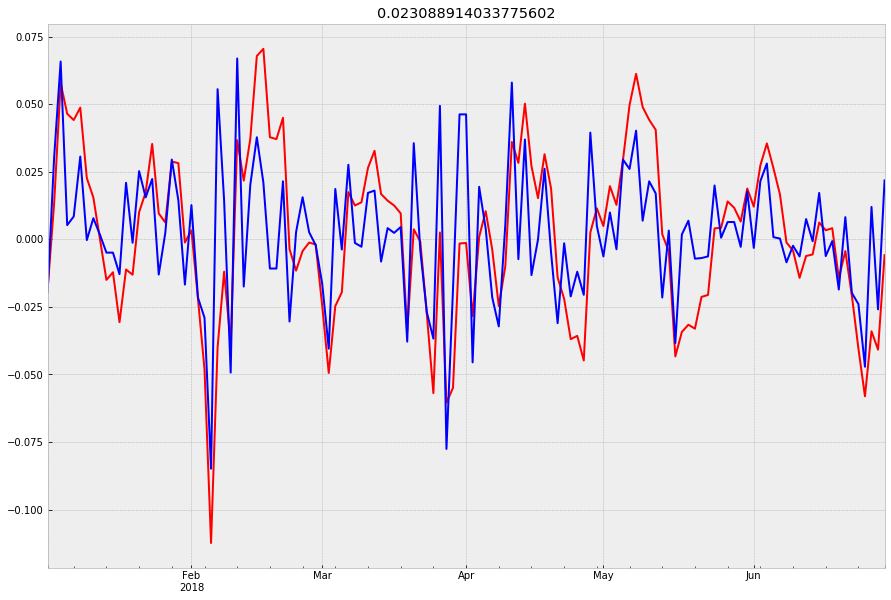

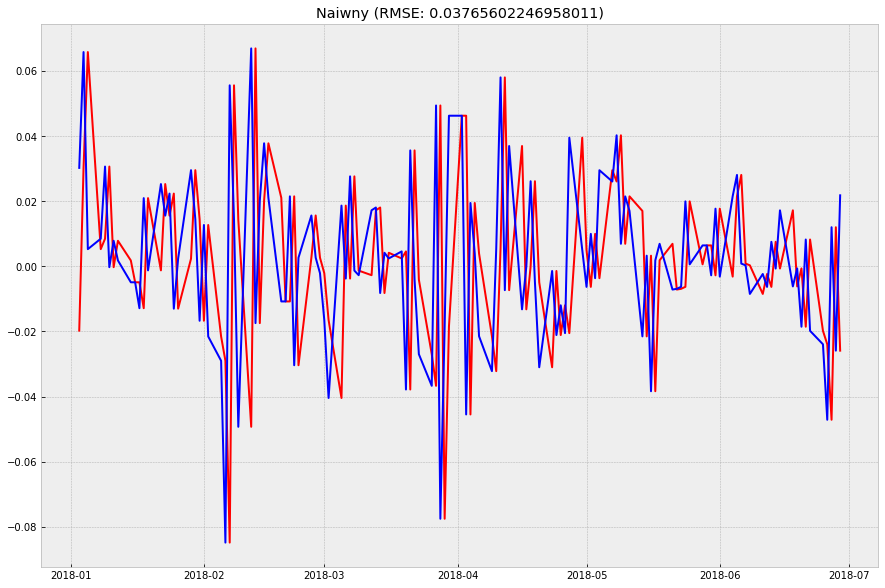

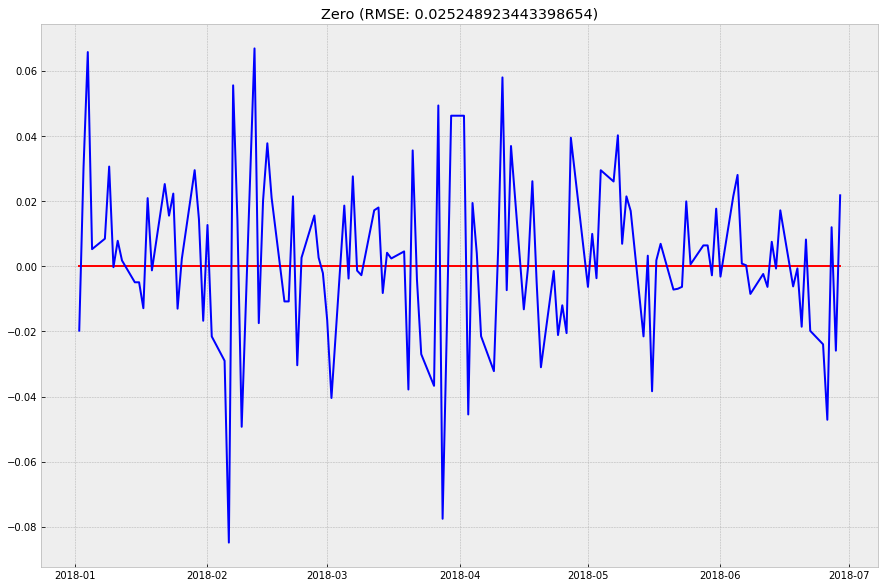

In [271]:
forecasts.plot(color='red', label='Forecast')
y_test_base.plot(color='blue', label='Real')
plt.title(rmse(y_test_base, forecasts))
plt.show()
show_est_plot(y_test_base, naiwny=True, label='Naiwny')
show_est_plot(y_test_base, zero=True, label='Zero')

## Test

In [272]:
order = (2,0,0)
variables = ['Will_R', 'T3', 'TSF', 'CEIL', 'close']
y_train_base = pd.concat([train1, val1, val2, val3]).asfreq('B', method='bfill')['return ratio']
x_train_base = pd.concat([train1, val1, val2, val3]).asfreq('B', method='bfill')[variables]
y_test_base = test['return ratio']
x_test_base = test[variables]
period = pd.concat([y_train, y_test])

In [273]:
model = SARIMAX(y_train_base, x_train_base, order=order, freq='B', trend='c')
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:           return ratio   No. Observations:                 1565
Model:               SARIMAX(2, 0, 0)   Log Likelihood                4033.459
Date:                Thu, 28 Mar 2019   AIC                          -8048.917
Time:                        14:42:14   BIC                          -8000.717
Sample:                    07-02-2012   HQIC                         -8030.999
                         - 06-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      1.369      0.171      -0.001       0.005
Will_R         0.0001   2.11e-05      6.273      0.000    9.09e-05       0.000
T3            -0.0022      0.000     -8.034      0.0

In [274]:
forecasts = []
for i in range(len(y_test_base)):
    y_train = pd.concat([y_train_base, y_test_base[:i]]).asfreq('B', method='bfill')
    x_train = pd.concat([x_train_base, x_test_base[:i]]).asfreq('B', method='bfill')
    model = SARIMAX(y_train, x_train, order=order, freq='B', trend='c')
    results = model.fit(disp=False, enforce_invertibility=False)
    forecasts.append(results.forecast(exog=x_test_base[i:i+1])[0])
forecasts = pd.Series(forecasts, index=y_test_base.index)

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood opti

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


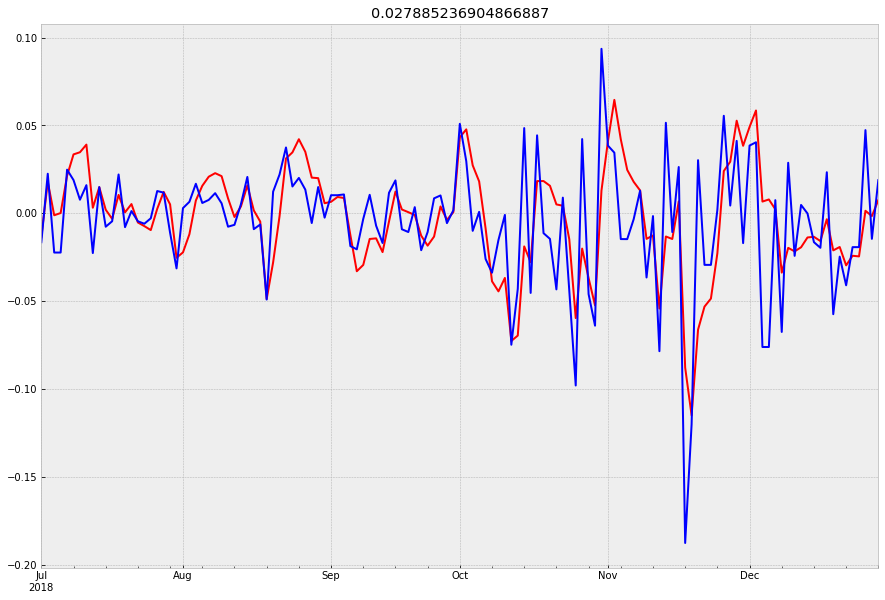

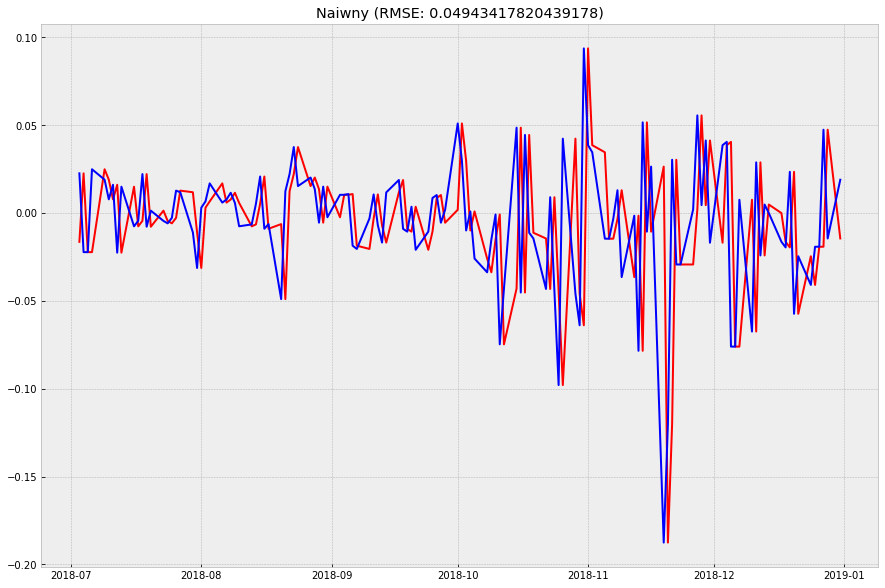

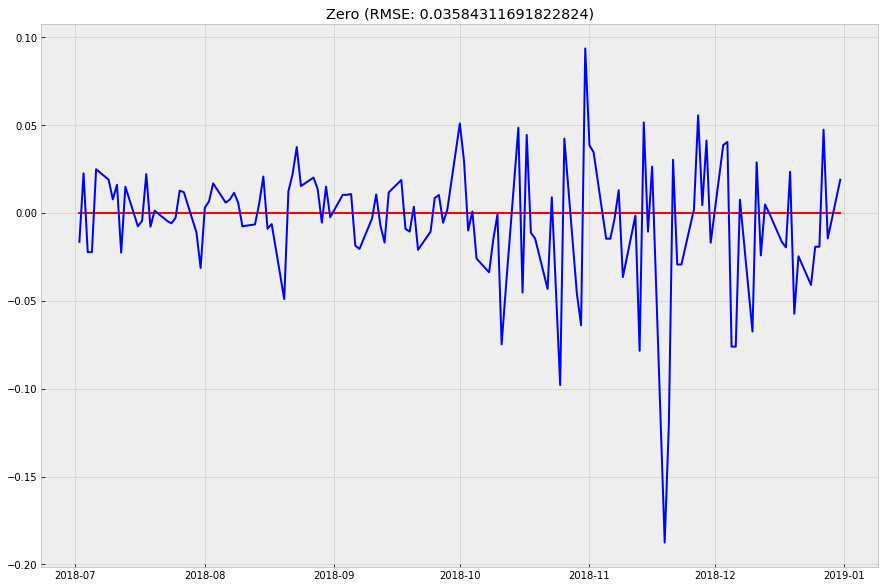

In [275]:
forecasts.plot(color='red', label='Forecast')
y_test_base.plot(color='blue', label='Real')
plt.title(rmse(y_test_base, forecasts))
plt.show()
show_est_plot(y_test_base, naiwny=True, label='Naiwny')
show_est_plot(y_test_base, zero=True, label='Zero')